In [10]:
#Libraries:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

In [2]:
#Read Data from System

imdb = pd.read_csv("imdb.csv")
print(imdb.shape)

(50000, 2)


In [3]:
#Checking first 5 rows
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Data Cleaning

In [4]:
sentiment = imdb['sentiment']

In [5]:
#Data Cleaning
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [6]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [7]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(imdb['review'].values):
    # remove urls from text python: https://stackoverflow.com/a/40823105/4084039
    sentance = re.sub(r"http\S+", "", sentance)
    # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    # https://stackoverflow.com/a/47091490/4084039
    sentance = decontracted(sentance)
    #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:23<00:00, 2130.39it/s]


In [11]:
def get_lemmatized_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

In [14]:
#nltk.download('wordnet')
preprocessed_reviews= get_lemmatized_text(preprocessed_reviews)

In [15]:
preprocessed_reviews[0]
imdb['preprocessed_review']=preprocessed_reviews

In [16]:
imdb.drop(['review'], axis=1, inplace=True)

In [17]:
y = imdb['sentiment'].values
X = imdb.drop(['sentiment'], axis=1)
X.head(1)

,preprocessed_review
0,one reviewer mentioned watching oz episode hoo...


# Splitting Data

In [18]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, stratify=y_train)

# Vectorization

In [19]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 

vectorizer_review = CountVectorizer(min_df=10,ngram_range=(1,4),binary=True)
vectorizer_review.fit(X_train['preprocessed_review'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_review_bow = vectorizer_review.transform(X_train['preprocessed_review'].values)
X_cv_review_bow = vectorizer_review.transform(X_cv['preprocessed_review'].values)
X_test_review_bow = vectorizer_review.transform(X_test['preprocessed_review'].values)

print("After vectorizations")
print(X_train_review_bow.shape, y_train.shape)
print(X_cv_review_bow.shape, y_cv.shape)
print(X_test_review_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(24500, 43353) (24500,)
(10500, 43353) (10500,)
(15000, 43353) (15000,)


In [20]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_review_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,4), binary=True)
vectorizer_review_tfidf.fit(X_train['preprocessed_review'].values)

# we use the fitted tfidfVectorizer to convert the text to vector
X_train_review_tfidf = vectorizer_review_tfidf.transform(X_train['preprocessed_review'].values)
X_cv_review_tfidf = vectorizer_review_tfidf.transform(X_cv['preprocessed_review'].values)
X_test_review_tfidf = vectorizer_review_tfidf.transform(X_test['preprocessed_review'].values)

print("After vectorizations")
print(X_train_review_tfidf.shape, y_train.shape)
print(X_cv_review_tfidf.shape, y_cv.shape)
print(X_test_review_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(24500, 43353) (24500,)
(10500, 43353) (10500,)
(15000, 43353) (15000,)


In [21]:
#Load Sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

In [92]:
#Model Learning using Train Data and CV data Accuracy

In [22]:
accuracy = []
regularization = [0.001,0.005,0.01, 0.05,0.1,0.15, 0.25, 0.5, 1,5,50]
for c in regularization:
    lr = LogisticRegression(C=c,penalty='l2')
    lr.fit(X_train_review_bow, y_train)
    accuracy.append(accuracy_score(y_cv, lr.predict(X_cv_review_bow)))
    print("Accuracy for C=%s: %s"
          % (c, accuracy_score(y_cv, lr.predict(X_cv_review_bow))))

Accuracy for C=0.001: 0.8552380952380952
Accuracy for C=0.005: 0.8761904761904762
Accuracy for C=0.01: 0.8826666666666667
Accuracy for C=0.05: 0.8913333333333333
Accuracy for C=0.1: 0.8924761904761904
Accuracy for C=0.15: 0.8917142857142857
Accuracy for C=0.25: 0.8915238095238095
Accuracy for C=0.5: 0.8913333333333333
Accuracy for C=1: 0.8902857142857142
Accuracy for C=5: 0.8869523809523809
Accuracy for C=50: 0.8841904761904762


In [93]:
#Finding best C value and applying it to final model

Final Accuracy: 0.8931333333333333
Highest C value: 0.1


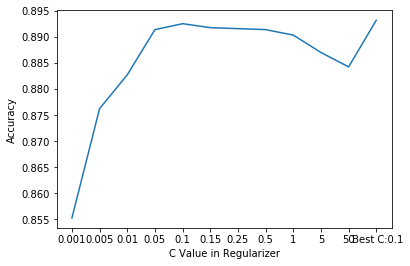

In [23]:

highestC = [regularization[i] for i in range(len(regularization)) if accuracy[i] == max(accuracy)][0]
final_model = LogisticRegression(C = highestC,penalty='l2')
final_model.fit(X_train_review_bow,y_train)
y_pred = final_model.predict(X_test_review_bow)
print("Final Accuracy: %s" % accuracy_score(y_test, y_pred))
print("Highest C value:", str(highestC))
accuracy.append(accuracy_score(y_test, final_model.predict(X_test_review_bow)))
regularization.append(' Best C:' + str(highestC))
plt.xlabel("C Value in Regularizer")
plt.ylabel("Accuracy")
plt.plot(regularization, accuracy)

In [24]:
# Printing best and worst review Words
feature_to_coef = {
    word: coef for word, coef in zip(
        vectorizer_review.get_feature_names(), final_model.coef_[0]
    )
}

print("Best Positive Terms:")
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
#     ('excellent', 0.9288812418118644)
#     ('perfect', 0.7934641227980576)
#     ('great', 0.675040909917553)
#     ('amazing', 0.6160398142631545)
#     ('superb', 0.6063967799425831)
    
print("Worst Negative Terms:")
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)
    
#     ('worst', -1.367978497228895)
#     ('waste', -1.1684451288279047)
#     ('awful', -1.0277001734353677)
#     ('poorly', -0.8748317895742782)
#     ('boring', -0.8587249740682945)

Best Positive Terms:
('excellent', 1.0435446227527214)
('one best', 0.8922437670804977)
('perfect', 0.8237892625025874)
('amazing', 0.7612471160579138)
('fantastic', 0.7309602712000715)
Worst Negative Terms:
('worst', -1.2356057751268428)
('waste', -1.2322048733822153)
('awful', -1.1433817030808666)
('dull', -0.9720718514499297)
('boring', -0.9301850313100261)


In [25]:
accuracy = []
regularization = [0.001,0.005,0.01, 0.05,0.1,0.15, 0.25, 0.5, 1,5,10,50]
for c in regularization:
    lr2 = LogisticRegression(C=c,penalty='l2')
    lr2.fit(X_train_review_tfidf, y_train)
    accuracy.append(accuracy_score(y_cv, lr2.predict(X_cv_review_tfidf)))
    print("Accuracy for C=%s: %s"
          % (c, accuracy_score(y_cv, lr2.predict(X_cv_review_tfidf))))

Accuracy for C=0.001: 0.8572380952380952
Accuracy for C=0.005: 0.8568571428571429
Accuracy for C=0.01: 0.8583809523809524
Accuracy for C=0.05: 0.8660952380952381
Accuracy for C=0.1: 0.8736190476190476
Accuracy for C=0.15: 0.8775238095238095
Accuracy for C=0.25: 0.8825714285714286
Accuracy for C=0.5: 0.8892380952380953
Accuracy for C=1: 0.8930476190476191
Accuracy for C=5: 0.9007619047619048
Accuracy for C=10: 0.8985714285714286
Accuracy for C=50: 0.8955238095238095


Final Accuracy: 0.9021333333333333
Highest C value: 5


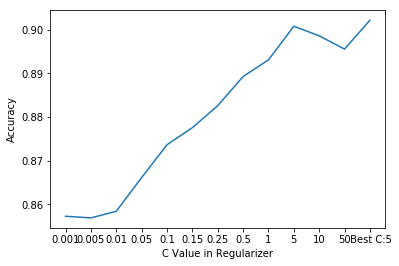

In [26]:
highestC = [regularization[i] for i in range(len(regularization)) if accuracy[i] == max(accuracy)][0]
final_model2 = LogisticRegression(C = highestC,penalty='l2')
final_model2.fit(X_train_review_tfidf,y_train)
y_pred2 = final_model2.predict(X_test_review_tfidf)
print("Final Accuracy: %s" % accuracy_score(y_test, y_pred2))
print("Highest C value:", str(highestC))
accuracy.append(accuracy_score(y_test, final_model2.predict(X_test_review_tfidf)))
regularization.append(' Best C:' + str(highestC))
plt.xlabel("C Value in Regularizer")
plt.ylabel("Accuracy")
plt.plot(regularization, accuracy)

In [27]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
print(str((tn, fp, fn, tp)))

(6637, 740, 863, 6760)


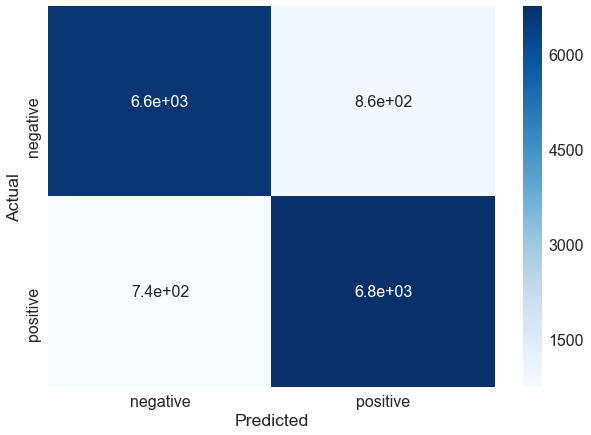

In [28]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.6)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

In [29]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_pred2, y_test).ravel()
print(str((tn, fp, fn, tp)))

(6707, 675, 793, 6825)


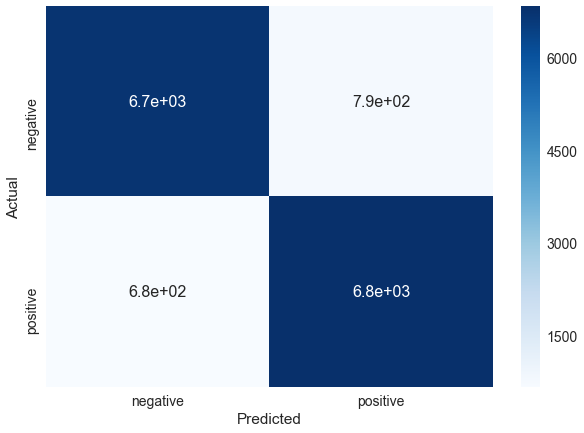

In [30]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


data2 = confusion_matrix(y_test, y_pred2)
df_cm = pd.DataFrame(data2, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

In [36]:
# pred_prob1 = final_model.predict_proba(X_test_review_bow)
# pred_prob2 = final_model2.predict_proba(X_test_review_tfidf)
# print(pred_prob1)

In [31]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
#Classification report for bag of words 
lr_bow_report=classification_report(y_test,y_pred,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,y_pred2,target_names=['Positive','Negative'])
print(lr_tfidf_report)

             precision    recall  f1-score   support

   Positive       0.90      0.88      0.89      7500
   Negative       0.89      0.90      0.89      7500

avg / total       0.89      0.89      0.89     15000

             precision    recall  f1-score   support

   Positive       0.91      0.89      0.90      7500
   Negative       0.90      0.91      0.90      7500

avg / total       0.90      0.90      0.90     15000



In [33]:
from sklearn.naive_bayes import MultinomialNB
model_nb = MultinomialNB()
model_nb.fit(X_train_review_tfidf, y_train)
y_pred_nb = model_nb.predict(X_test_review_tfidf)
print("Final Accuracy: %s" % accuracy_score(y_test, y_pred_nb))

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_pred_nb, y_test).ravel()
print(str((tn, fp, fn, tp)))

Final Accuracy: 0.8814666666666666
(6483, 761, 1017, 6739)


In [34]:
from sklearn.svm import LinearSVC

accuracy = []
regularization = [0.01, 0.05, 0.25, 0.5, 1]
for c in regularization:
    lr_svc = LinearSVC(C=c)
    lr_svc.fit(X_train_review_tfidf, y_train)
    accuracy.append(accuracy_score(y_cv, lr_svc.predict(X_cv_review_tfidf)))
    print("Accuracy for C=%s: %s"
          % (c, accuracy_score(y_cv, lr_svc.predict(X_cv_review_tfidf))))



Accuracy for C=0.01: 0.8714285714285714
Accuracy for C=0.05: 0.8898095238095238
Accuracy for C=0.25: 0.9007619047619048
Accuracy for C=0.5: 0.9014285714285715
Accuracy for C=1: 0.8962857142857142


In [35]:

# train final model with highest c
highestC = [regularization[i] for i in range(len(regularization)) if accuracy[i] == max(accuracy)][0]
model_svc = LinearSVC(C = highestC)
model_svc.fit(X_train_review_tfidf, y_train)
y_pred_svc = model_svc.predict(X_test_review_tfidf)
print("Final Accuracy: %s" % accuracy_score(y_test, y_pred_svc))
print(str(highestC))
accuracy.append(accuracy_score(y_test, final_model.predict(X_test_review_tfidf)))
regularization.append('testError C:' + str(highestC))

Final Accuracy: 0.9021333333333333
0.5


In [36]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_pred_svc, y_test).ravel()
print(str((tn, fp, fn, tp)))

(6708, 676, 792, 6824)


In [42]:
from sklearn.ensemble import GradientBoostingClassifier
accuracy = []
treeDepth = [4, 5, 6]
for c in treeDepth:
    gbc = GradientBoostingClassifier(max_depth=c)
    gbc.fit(X_train_review_tfidf, y_train)
    accuracy.append(accuracy_score(y_cv, gbc.predict(X_cv_review_tfidf)))
    print("Accuracy for C=%s: %s"
          % (c, accuracy_score(y_cv, gbc.predict(X_cv_review_tfidf))))

Accuracy for C=4: 0.8178095238095238
Accuracy for C=5: 0.8232380952380952
Accuracy for C=6: 0.8267619047619048


In [39]:
# train final model with highest c
# highestC = [treeDepth[i] for i in range(len(treeDepth)) if accuracy[i] == max(accuracy)][0]
model_gbc = GradientBoostingClassifier(max_depth= 5)
model_gbc.fit(X_train_review_tfidf, y_train)
y_pred_gbc = model_gbc.predict(X_test_review_tfidf)
print("Final Accuracy: %s" % accuracy_score(y_test, y_pred_gbc))

Final Accuracy: 0.827


In [38]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(random_state=25)
model_dt.fit(X_train_review_tfidf, y_train)
y_pred_dt = model_dt.predict(X_test_review_tfidf)
print("Final Accuracy: %s" % accuracy_score(y_test, y_pred_dt))

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_pred_dt, y_test).ravel()
print(str((tn, fp, fn, tp)))

Final Accuracy: 0.7190666666666666
(5412, 2126, 2088, 5374)


In [41]:
print("Logistic Regression with n_gram")
lr_bow_report=classification_report(y_test,y_pred,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
print("Logistic Regression with tfidf")
lr_tfidf_report=classification_report(y_test,y_pred2,target_names=['Positive','Negative'])
print(lr_tfidf_report)


print("Naive Bayes with tfidf")
nb_tfidf_report=classification_report(y_test,y_pred_nb,target_names=['Positive','Negative'])
print(nb_tfidf_report)

#Classification report for tfidf features
print("SVC with tfidf")
svc_tfidf_report=classification_report(y_test,y_pred_svc,target_names=['Positive','Negative'])
print(svc_tfidf_report)

#Classification report for tfidf features
print("Decision tree with tfidf")
dt_tfidf_report=classification_report(y_test,y_pred_dt,target_names=['Positive','Negative'])
print(dt_tfidf_report)

#Classification report for tfidf features
print("Random Forest with tfidf")
gbc_tfidf_report=classification_report(y_test,y_pred_gbc,target_names=['Positive','Negative'])
print(gbc_tfidf_report)

Logistic Regression with n_gram
             precision    recall  f1-score   support

   Positive       0.90      0.88      0.89      7500
   Negative       0.89      0.90      0.89      7500

avg / total       0.89      0.89      0.89     15000

Logistic Regression with tfidf
             precision    recall  f1-score   support

   Positive       0.91      0.89      0.90      7500
   Negative       0.90      0.91      0.90      7500

avg / total       0.90      0.90      0.90     15000

Naive Bayes with tfidf
             precision    recall  f1-score   support

   Positive       0.89      0.86      0.88      7500
   Negative       0.87      0.90      0.88      7500

avg / total       0.88      0.88      0.88     15000

SVC with tfidf
             precision    recall  f1-score   support

   Positive       0.91      0.89      0.90      7500
   Negative       0.90      0.91      0.90      7500

avg / total       0.90      0.90      0.90     15000

Decision tree with tfidf
             p